In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchmetrics.classification import Dice
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import random
import torch
from utils import unet, mypreprocess, util_functions, eff_unet
from tqdm import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import json
import warnings
warnings.filterwarnings("ignore")
import math
import gc
import albumentations as A
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler

/home/student/sinaziaee/mini_conda/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = '/scratch/student/sinaziaee/datasets/2d_dataset'
train_dir = os.path.join(base_path, 'training')
valid_dir = os.path.join(base_path, 'validation')
img_size = 512

def apply_gaussian_noise(image, std_dev=0.1, rows=None, cols=None):
    # Add Gaussian noise to the image
    gauss = np.random.normal(0, std_dev, image.shape)
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

# Spatial transformations (applied to both image and label)
spatial_transforms = A.Compose([
    A.Rotate(limit=360, p=1.0), 
    A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.7, 1.4), p=1.0),
    A.Lambda(image=transforms.ToTensor())
    # A.Lambda(image=torch.from_numpy()),
], additional_targets={'label': 'image'})

# # Non-spatial transformations (applied only to the image)
# non_spatial_transforms = A.Compose([
#     A.GaussianBlur(blur_limit=3, p=0.5),
#     A.ColorJitter(brightness=0.25, contrast=0.5, p=1.0),
#     A.Lambda(image=apply_gaussian_noise, p=0.1),
#     A.ToFloat(max_value=255.0),
#     A.Lambda(image=transforms.ToTensor())
#     # A.Lambda(image=torch.from_numpy()),
# ])

# train_transformer = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomRotation(2*math.pi),
#     transforms.RandomResizedCrop(img_size, scale=(0.7, 1.4)),
#     transforms.GaussianBlur(1),
#     transforms.ColorJitter(brightness=(0.75, 1.25), contrast=(0.5, 2)),
#     transforms.Lambda(lambda img: util_functions.apply_gaussian_noise(img, std_dev=0.1) if torch.rand(1) < 0.1 else img)
# ])

valid_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size), antialias=True),
])
batch_size = 84

plain_train_loader = mypreprocess.create_data_loaders(path_dir=train_dir, image_dir='images', 
                            label_dir='labels', data_transformer=valid_transformer, batch_size=batch_size, split_size=None)
augmented_train_loader = mypreprocess.create_data_loaders(path_dir=train_dir, image_dir='images', 
                            label_dir='labels', data_transformer=valid_transformer, 
                            batch_size=batch_size, split_size=None)
# augmented_train_loader = mypreprocess.create_data_loaders(path_dir=train_dir, image_dir='images', 
#                             label_dir='labels', data_transformer=train_transformer, 
#                             batch_size=batch_size, split_size=None)
train_loader = DataLoader(ConcatDataset([plain_train_loader.dataset, augmented_train_loader.dataset]), batch_size=batch_size, shuffle=True)
valid_loader = mypreprocess.create_data_loaders(path_dir=valid_dir, image_dir='images', 
                                            label_dir='labels', data_transformer=valid_transformer, batch_size=batch_size, split_size=None)

# train_loader = valid_loader
train_loader = plain_train_loader

# del plain_train_loader
# del augmented_train_loader

# Run garbage collection to free up memory
gc.collect()
print("Size of the training dataset:", len(train_loader.dataset))

dataset info: 
 No images: 15033, No masks: 15033, 
 No of batches: 179, batch shape: torch.Size([84, 1, 512, 512])
dataset info: 
 No images: 15033, No masks: 15033, 
 No of batches: 179, batch shape: torch.Size([84, 1, 512, 512])
dataset info: 
 No images: 737, No masks: 737, 
 No of batches: 9, batch shape: torch.Size([84, 1, 512, 512])
Size of the training dataset: 15033


torch.Size([84, 1, 512, 512])
Len of train_loader: 179


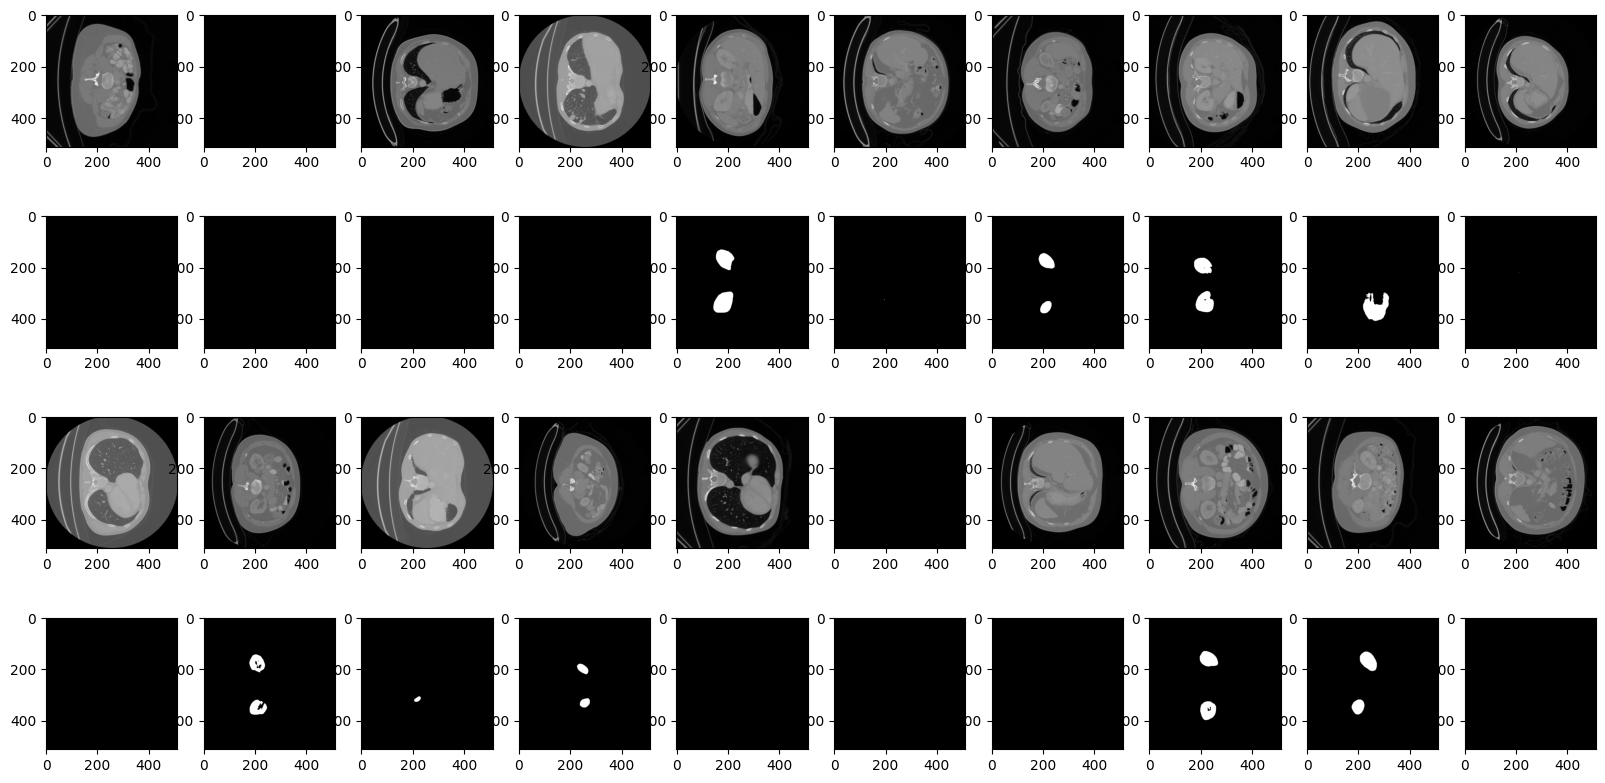

In [3]:
util_functions.visualize_dataset(plain_train_loader)

# DataSet size
original number of 2d images for training: 15033, validation: 733

after augmentation the number of training images are 30066, validation 733

In [4]:
def train_fn(data_loader, model, criterion, optimizer, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.train()
    total_loss = 0
    for batch in data_loader:
        if is_parallel is False:
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)
        else:
            images, masks = batch[0].to(device_0), batch[1].to(device_1)
        
        outputs = model(images)
        
        optimizer.zero_grad() 
        # print(outputs.shape) 
        # print(masks.shape)
        loss1 = criterion(outputs, masks)
        if criterion2 is not None:
            loss2 = criterion2(outputs, masks)
            loss = loss1 + loss2
        else:
            loss = loss1
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [5]:
def dice_coefficient3(target, preds):
    temp = torch.zeros_like(preds[:, 0])
    temp[temp > 0.5] = 1
    preds = temp.unsqueeze(1)
    intersection = (preds * target).sum().float()
    set_sum = preds.sum() + target.sum()

    dice = (2 * intersection + 1e-8) / (set_sum + 1e-8)

    return dice

def dice_coefficient4(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice   

In [6]:
def eval_fn(data_loader, model, criterion, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.eval()
    total_loss = 0
    total_iou = 0
    with torch.no_grad():
        for batch in data_loader:
            if is_parallel is False:
                images, masks = batch
                images = images.to(device)
                masks = masks.to(device)
            else:
                images, masks = batch[0].to(device_0), batch[1].to(device_1)
            
            outputs = model(images)
            if criterion2 == None:
                loss = criterion(outputs, masks)
            else:
                loss = criterion(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss.item()
            iou = util_functions.calculate_IoU(outputs, masks)
            total_iou += iou.item()
            dice_value = dice_coefficient3(masks, outputs).item()
            # dice_metric = Dice()
            # print(outputs.shape, masks.shape)
            # dice_value = dice_metric(outputs, masks).item()
            # dice_value = 0
        
        avg_loss = total_loss / len(data_loader)
        avg_iou = total_iou / len(data_loader)
    return avg_loss, avg_iou, dice_value

In [7]:
def train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device,
                                criterion1, criterion2 = None, device_0 = None, device_1 = None, is_parallel=True, scheduler=None):
    if is_parallel is False:
        model = model.to(device)
    else:
        model = nn.DataParallel(model, device_ids=[0, 1])
        
    best_valid_loss = np.Inf

    train_loss_list = []
    valid_loss_list = []
    valid_iou_list = []
    valid_dice_list = []

    results_folder = util_functions.create_result_folder(path='results')
    print(results_folder)
    for epoch in tqdm(range(n_epochs)):
        train_loss = train_fn(data_loader=train_loader, model=model, criterion=criterion1, 
                              optimizer=optimizer, device=device, criterion2=criterion2,
                              is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        valid_loss, valid_iou, valid_dice = eval_fn(data_loader=valid_loader, model=model, criterion=criterion1,
                                        device=device, criterion2=criterion2,
                                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        
        scheduler.step()
        
        # Access the current learning rate
        current_lr = scheduler.get_lr()[0]
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        valid_iou_list.append(valid_iou)
        valid_dice_list.append(valid_dice)
        
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss
            directory = 'results'
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save(model.state_dict(), f'{results_folder}/best_model.pt')
            print('SAVED-MODEL')
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, lr: {current_lr}')
            util_functions.visualize_training(train_loss_list=train_loss_list, valid_loss_list=valid_loss_list,
                                            valid_iou_list=valid_iou_list, valid_dice_list=valid_dice_list, results_folder=results_folder)
            
        lists_dict = {
            'train_loss_list': train_loss_list,
            'valid_loss_list': valid_loss_list,
            'valid_iou_list': valid_iou_list,
            'valid_dice_list': valid_dice_list,
        }

        with open(f'{results_folder}/training_trend.json', 'w') as f:
            json.dump(lists_dict, f)
                

In [8]:
is_parallel = False
# Parallel training
# model = unet.UNet(num_classes=1, input_channels=1)
model = eff_unet.EffUNet(in_channels=1, classes=1)
# model = smp.Unet(classes=1, in_channels=1)
# model.load_state_dict(torch.load('results/best_model.pt'))
device = torch.device('cuda:0')
print(device)
device_0 = torch.device('cuda:0')
device_1 = torch.device('cuda:1')
if is_parallel is True:
    model.to(device_0)
    model.to(device_1)
    model = nn.DataParallel(model, device_ids=[0, 1])
else:
    model.to(device)

cuda:0


results/2023-11-12_13-30


  0%|          | 0/31 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1, Train Loss: 0.9620695257320084, Valid Loss: 0.9654317763116624, lr: 0.1


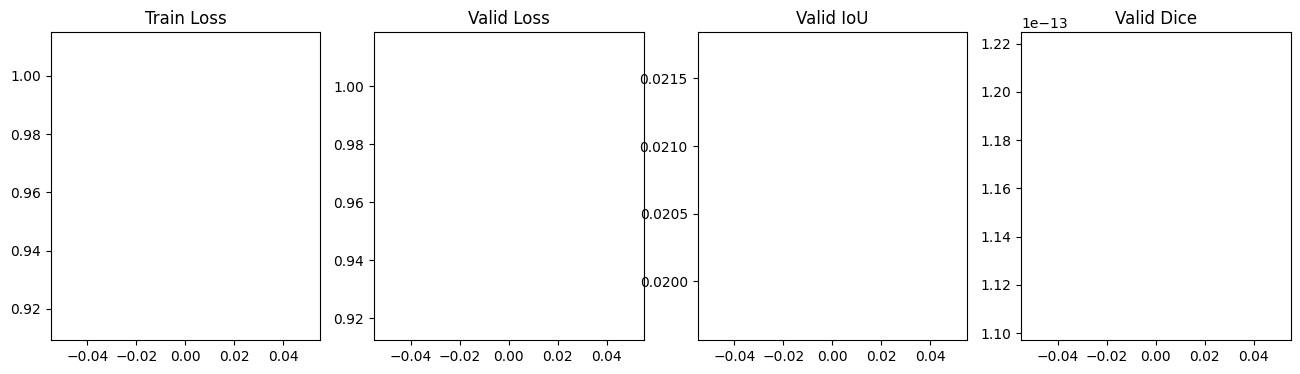

  6%|▋         | 2/31 [06:35<1:35:27, 197.51s/it]

SAVED-MODEL


 10%|▉         | 3/31 [09:52<1:32:04, 197.29s/it]

SAVED-MODEL


 13%|█▎        | 4/31 [13:09<1:28:44, 197.21s/it]

SAVED-MODEL


 19%|█▉        | 6/31 [19:43<1:22:08, 197.16s/it]

SAVED-MODEL


 23%|██▎       | 7/31 [23:00<1:18:52, 197.19s/it]

SAVED-MODEL


 32%|███▏      | 10/31 [32:51<1:08:55, 196.92s/it]

Epoch: 11, Train Loss: 0.07926883577634503, Valid Loss: 0.08044170671039158, lr: 0.0010000000000000002


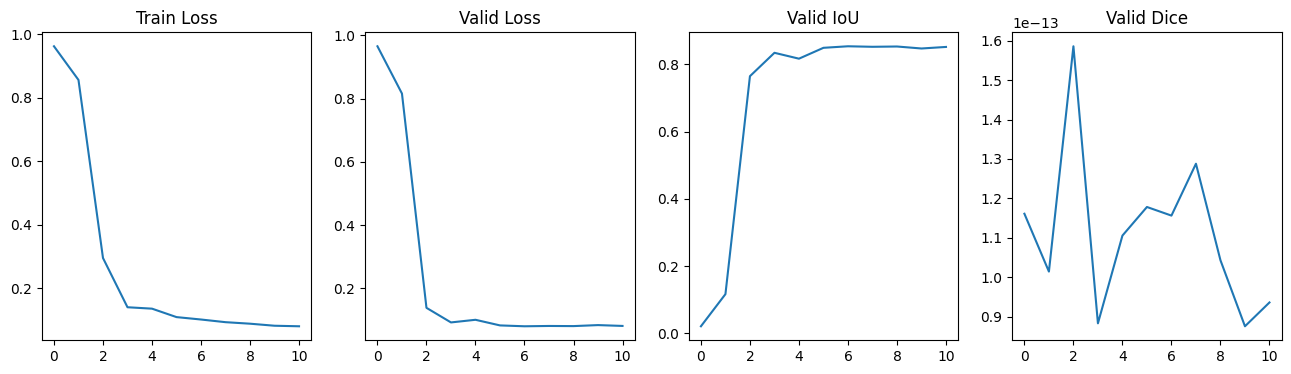

 42%|████▏     | 13/31 [42:41<59:03, 196.88s/it]  

In [9]:
criterion1 = DiceLoss(mode="binary")
criterion2 = nn.BCEWithLogitsLoss()
learning_rate = 0.1
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
n_epochs = 31

train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, None,
                        is_parallel=is_parallel, device_0=device_0, device_1=device_1, scheduler=scheduler)

In [11]:
torch.cuda.empty_cache()

In [ ]:
is_parallel = False
model = unet.UNet(num_classes=1, input_channels=1)
# model = smp.Unet(classes=1, in_channels=1)
model.load_state_dict(torch.load('results/2023-11-10_22-52/best_model.pt'))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')
device_0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_1 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
if is_parallel is True:
    model.to(device_0)
    model.to(device_1)
    model = nn.DataParallel(model, device_ids=[0, 1])
else:
    model.to(device)
print(device)

In [ ]:
train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, None,
                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)

In [ ]:
model = eff_unet.EffUNet(in_channels=1, classes=1)
model.load_state_dict(torch.load('results/2023-11-10_22-52/best_model.pt'))
device = torch.device('cuda:0')
t_list = [i for i in range(64)]
for idx in t_list:
    data_iter = iter(valid_loader)
    images, masks = next(data_iter)
    image = images[idx]
    mask = masks[idx]
    logits_mask = model(image.to(device).unsqueeze(0))
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0
    util_functions.show_image(image, mask, pred_mask.detach().cpu().squeeze(0), path_dir='results/2023-11-10_22-52/preds', num=idx)

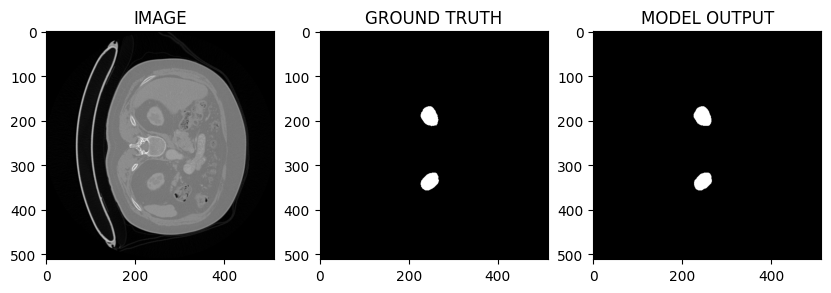

In [13]:
util_functions.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [15]:
model = unet.UNet(input_channels=1, num_classes=1)
model.load_state_dict(torch.load('results/best_model.pt'))
model = model.to(device)

  0%|          | 0/500 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1, Train Loss: 0.7166332229971886, Valid Loss: 0.33545786142349243


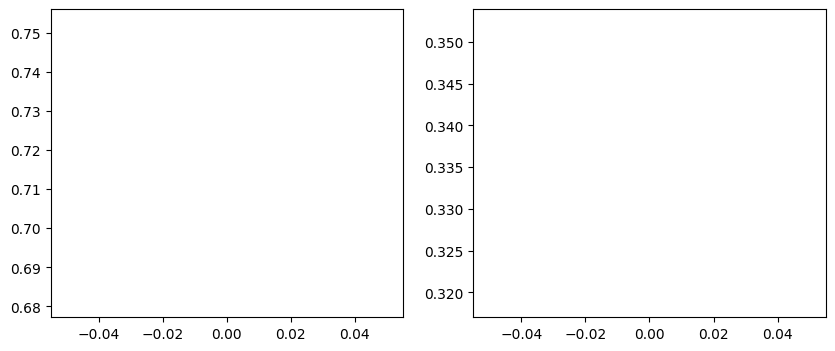

 10%|█         | 50/500 [47:29<7:08:19, 57.11s/it]

Epoch: 51, Train Loss: 0.7128799110651016, Valid Loss: 0.33545786142349243


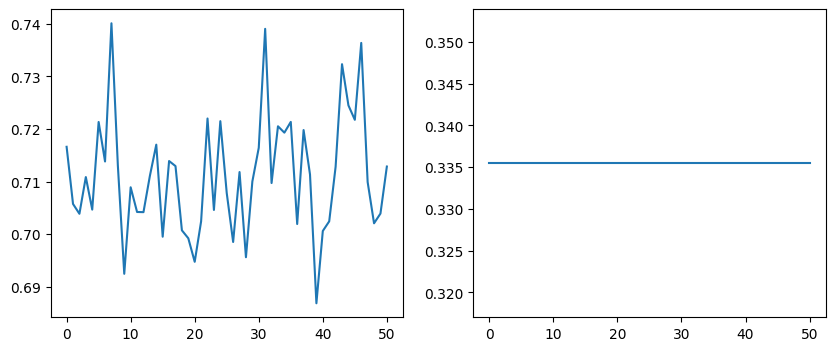

 20%|██        | 100/500 [1:34:22<6:43:47, 60.57s/it]

Epoch: 101, Train Loss: 0.7238178551197052, Valid Loss: 0.33545786142349243


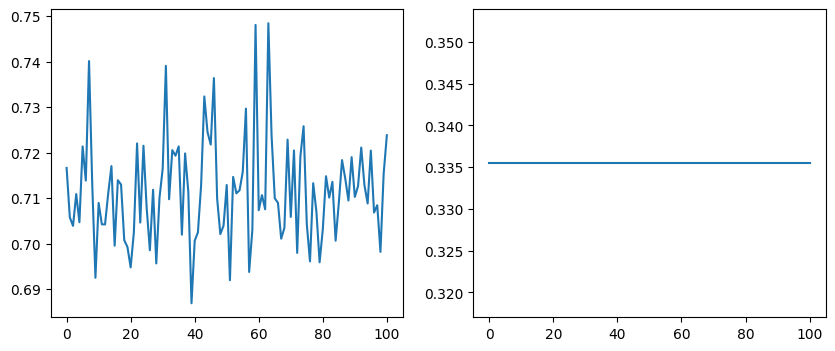

 21%|██        | 105/500 [1:40:02<6:16:20, 57.16s/it]


KeyboardInterrupt: 

In [18]:
train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, criterion2)